In [1]:
from pathlib import Path
from PIL import ImageFile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

%matplotlib inline

# To avoid PIL throwing the error "OSError: image file is truncated". 
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define the data path
data_path = Path("__file__").cwd() / "maize_dataset"

In [2]:
class LoadDataset:
    """
    Class to ingest data using training and test loaders. 
    """

    def __init__(self, data_path):
        self.data_path = data_path
        # Define Data Transformation
        self.transformation = transforms.Compose([
            # Resize to a common 128 * 128 image size
            transforms.Resize(size=[128, 128]),
            # Transform to tensors
            transforms.ToTensor(),
            # Normalize the pixel values (in R, G, and B channels)
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        # Load all the images, transforming them
        self.full_dataset = ImageFolder(root=data_path, transform=self.transformation)

    def data_classes(self):
        """Get the class and class index"""
        classes = self.full_dataset.classes
        classes_indx = self.full_dataset.class_to_idx

        return classes, classes_indx

    def data_loaders(self, train_size=0.7):
        """ Get the iterative data loaders for test and training data """

        # Split into training (70%) and testing (30%) datasets
        train_size = int(train_size * len(self.full_dataset))
        test_size = len(self.full_dataset) - train_size
        # generator = torch.manual_seed(42)  # Set the seed to ensure consistent results
        train_dataset, test_dataset = random_split(dataset=self.full_dataset, 
                                                   lengths=[train_size, test_size],
                                                   # generator=generator
                                                   )

        # Define a loader for the training data we can iterate through in 50-image batches
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=50,
                                  num_workers=0,
                                  shuffle=False)

        # Define a loader for the testing data we can iterate through in 50-image batches
        test_loader = DataLoader(dataset=test_dataset,
                                 batch_size=50,
                                 num_workers=0,
                                 shuffle=False)

        return train_loader, test_loader 
    
# Get the iterative data loaders for test and training data
load_dataset = LoadDataset(data_path=data_path)
train_loader, test_loader = load_dataset.data_loaders()
classes, class_indexes = load_dataset.data_classes()
print('Data loaders ready!')   

Data loaders ready!


In [3]:
# Define a CNN Model
class Net(nn.Module):
    """ Create a neural net class """
    def __init__(self, num_classes=3):
        # num_classes is 3 because we have 3 classes: Health, MLN, and MSV
        super(Net, self).__init__()
        
        # Our images are RGB, so input_channels=3. 
        # We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=12,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolution layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, 
                               out_channels=12,
                               kernel_size=3,
                               stride=1, 
                               padding=1)
        
        # A third convolutional layers takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12,
                               out_channels=24,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout(p=0.2)
        
        # Our 128*128 image tensors will be pooled twice with a kernel size 0f 2. 
        # 128/2/2 is 32. So our feature tensors are now 32 * 32, and we have generated 24 of them. 
        # We need to flatten these and feed them to a fully-connected layer to map them to the probability of each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
        
    def forward(self, x):
        # Use a ReLu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
        
        # Use a ReLu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass. 
        # By default, self.training flag is set to True, i.e. modules are in train mode by default
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        
        # Return log_softmax tensor
        return F.log_softmax(x, dim=1)
        
print("CNN model class defined!")

CNN model class defined!


In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print(f"Epoch: {epoch}")
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches, so we see some progress
        if batch_idx % 10 == 0:
            print(
                f"Training set [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)] Loss: {loss.item():.6F}")

    # Return average loss for the epoch
    avg_loss = train_loss / (batch_idx + 1)
    print(f"Training set: Average loss: {avg_loss:.6f}")

    return avg_loss 

In [5]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't propagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    
    # Context manager to disable gradient calculation
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
    
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print(f"Validation set: Average loss: {avg_loss:.6f}, "
          f"Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({100. * correct / len(test_loader.dataset):.0f}%\n)")
    
    # Return average loss for the epoch
    return  avg_loss

In [6]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device!") 

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights, 
# and weight decay for L2 regularization to avoid overfitting
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Training over 5 epochs (in a real scenario, you'd likely to use many more)
epochs = 5
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Using cuda device!
Epoch: 1
Training set [0/10745 (0%)] Loss: 1.106518
Training set [500/10745 (5%)] Loss: 0.844876
Training set [1000/10745 (9%)] Loss: 0.605327
Training set [1500/10745 (14%)] Loss: 0.436309
Training set [2000/10745 (19%)] Loss: 0.233811
Training set [2500/10745 (23%)] Loss: 0.240660
Training set [3000/10745 (28%)] Loss: 0.530515
Training set [3500/10745 (33%)] Loss: 0.355590
Training set [4000/10745 (37%)] Loss: 0.372490
Training set [4500/10745 (42%)] Loss: 0.187417
Training set [5000/10745 (47%)] Loss: 0.285996
Training set [5500/10745 (51%)] Loss: 0.200979
Training set [6000/10745 (56%)] Loss: 0.383220
Training set [6500/10745 (60%)] Loss: 0.178416
Training set [7000/10745 (65%)] Loss: 0.188346
Training set [7500/10745 (70%)] Loss: 0.414420
Training set [8000/10745 (74%)] Loss: 0.179876
Training set [8500/10745 (79%)] Loss: 0.144219
Training set [9000/10745 (84%)] Loss: 0.403022
Training set [9500/10745 (88%)] Loss: 0.178810
Training set [10000/10745 (93%)] Loss: 

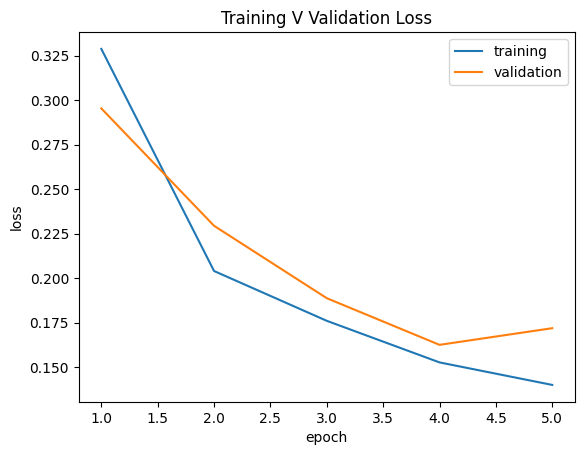

In [7]:
# Plot to view the history loss
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.title("Training V Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting  predictions from test set...


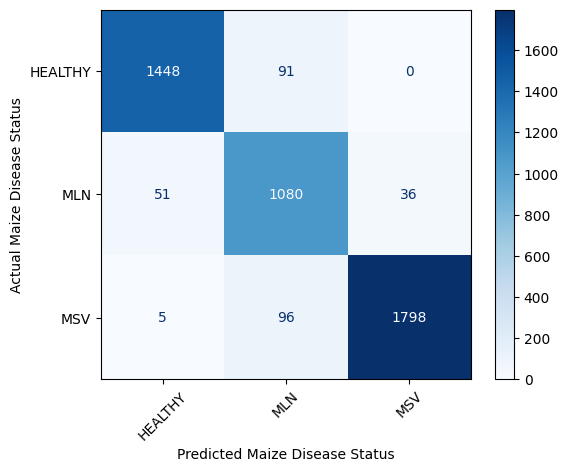

In [8]:
# Evaluate the model performance
# Using Scikit-learn confusion matrix since Pytorch doesn't have an inbuilt method for that.
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay) 

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with Scikit-learn
print("Getting  predictions from test set...")
true_labels = []
predictions = []


for data, target in test_loader:
    for label in target.cpu().data.numpy():
        true_labels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction)
                
# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
# plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
# plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Maize Disease Status")
plt.ylabel("Actual Maize Disease Status")
plt.show()

In [9]:
# Save the trained model

# Check if the models folder exists
models_folder_path = Path("__file__").cwd().parent / "models"
if not models_folder_path.exists():
    # If it doesn't exist, create it
    models_folder_path.mkdir(parents=True)
    print(f"Folder '{models_folder_path}' created!")
else:
    print(f"Folder '{models_folder_path}' already exists!")

# Define the model file path
model_file_path =  models_folder_path / "maize_classifier.pt"
torch.save(model.state_dict(), 
          model_file_path)
del model

print(f"Model saved as {model_file_path}")

Folder 'C:\Users\Evan\Documents\Ycenter\data_science_programme\models' already exists!
Model saved as C:\Users\Evan\Documents\Ycenter\data_science_programme\models\maize_classifier.pt
